# Notebook 32: Assigning SFR and [Fe/H] to galaxies sampled from the GSMF

This notebook generates figures 1 and 10 of de Sá, Bernardo et al. (2024).

## Prelude

In [1]:
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm

import sys
sys.path.append('../src')
from bossa.sampling import GalaxyGrid
from bossa.utils import ZOH_to_FeH, ZOH_to_FeH2, ZOH_from_FeH, FeH_to_Z
from bossa.constants import LOGE, LN10, GALAXYGRID_DIR_PATH

In [2]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [3]:
llim_feh = -2.25
ulim_feh = 0.45
llim_zoh = ZOH_from_FeH(llim_feh)
ulim_zoh = ZOH_from_FeH(ulim_feh)

In [4]:
logm_min = 6
logm_max = 12

In [5]:
highmet_MZR = 'KK04'
highmet_SFMR = 'none'
highmet_GSMF_fixedslope =  True

midmet_MZR = 'M09'
midmet_SFMR = 'moderate'
midmet_GSMF_fixedslope =  True

lowmet_MZR = 'PP04'
lowmet_SFMR = 'sharp'
lowmet_GSMF_fixedslope =  True

#### A SFR-uniform square grid

In [8]:
sfrsq_list = np.array([-2, -1, 0, 1, 2, 3])

In [9]:
sfrsq_met_list = np.arange(-5, 2, 1)
sfrsq_met_list = np.tile(sfrsq_met_list, (len(sfrsq_list),1))

In [10]:
n_columns = 2 # sfr feh
columns = ['Log(SFR [Msun yr-1])', '[Fe/H]']

sfrsq_grid_array = np.empty((0, n_columns), np.float64)
for sfr, fehs in zip(sfrsq_list, sfrsq_met_list):
    lines = np.array([fehs], np.float64).T
    for line in lines:
        sfrsq_grid_array = np.append(sfrsq_grid_array, [np.concatenate(([np.float64(sfr)], line))], axis=0)

sfrsq_grid_df = pd.DataFrame(sfrsq_grid_array, columns=columns)

#### A redshift-uniform square grid

In [11]:
n_redshift = 11
redshift_min = 0
redshift_max = 10
force_boundary_redshift = False
logm_per_redshift = 10
logm_min = 6
logm_max = 12
mzr_model = midmet_MZR
sfmr_flattening = midmet_SFMR
gsmf_slope_fixed = midmet_GSMF_fixedslope
sampling_mode = 'uniform' # uniform, mass or number
scatter_model = 'none'
apply_igimf_corrections = True
random_state = 42

In [12]:
zsq_galaxysampling = GalaxyGrid(n_redshift=n_redshift,
                                redshift_min=redshift_min,
                                redshift_max=redshift_max,
                                force_boundary_redshift=force_boundary_redshift,
                                logm_per_redshift=logm_per_redshift,
                                logm_min=logm_min,
                                logm_max=logm_max,
                                mzr_model=mzr_model,
                                sfmr_flattening=sfmr_flattening,
                                gsmf_slope_fixed=gsmf_slope_fixed,
                                sampling_mode=sampling_mode,
                                scatter_model=scatter_model,
                                apply_igimf_corrections=apply_igimf_corrections,
                                random_state=random_state)

In [13]:
%%time
zsq_galaxysampling.get_sample()

CPU times: user 2.73 s, sys: 2.91 ms, total: 2.73 s
Wall time: 2.86 s


In [14]:
sample_redshift_array = zsq_galaxysampling.sample_redshift_array
mass_list = zsq_galaxysampling.mass_list
zoh_list = zsq_galaxysampling.zoh_list
feh_list = zsq_galaxysampling.feh_list
sfr_list = zsq_galaxysampling.sfr_list
log_gsmf_list = zsq_galaxysampling.log_gsmf_list
gsmf_list = [10.**log_gsmf for log_gsmf in log_gsmf_list]

In [15]:
n_columns = 6 # redshift, galaxy mass, density, sfr, zoh, feh
columns = ['Redshift', 'Log(Mgal/Msun)', 'Log(Number density [Mpc-3 Msun-1])', 'Log(SFR [Msun yr-1])', '12+log(O/H)', '[Fe/H]']

zsq_grid_array = np.empty((0, n_columns), np.float64)
for z, masses, densities, sfrs, zohs, fehs in zip(sample_redshift_array, mass_list, gsmf_list,  sfr_list, zoh_list, feh_list):
    lines = np.array([masses, densities, sfrs, zohs, fehs], np.float64).T
    for line in lines:
        zsq_grid_array = np.append(zsq_grid_array, [np.concatenate(([np.float64(z)], line))], axis=0)

zsq_grid_df = pd.DataFrame(zsq_grid_array, columns=columns)

In [17]:
zsq_grid_df.describe()

,Redshift,Log(Mgal/Msun),Log(Number density [Mpc-3 Msun-1]),Log(SFR [Msun yr-1]),12+log(O/H),[Fe/H]
count,110.00000,110.000000,1.100000e+02,110.000000,110.000000,110.000000
mean,5.00000,8.990067,9.103771e-03,0.394791,7.221657,-2.020808
std,3.17675,1.715369,2.291437e-02,1.150983,1.150265,1.288705
min,0.00000,6.298500,1.574912e-14,-2.127792,4.483863,-4.846137
25%,2.00000,7.503000,2.068080e-05,-0.530955,6.436313,-2.893687
50%,5.00000,9.003000,4.410273e-04,0.387125,7.248620,-2.081380
75%,8.00000,10.497000,5.729006e-03,1.285419,8.057039,-1.272961
max,10.00000,11.704500,1.573304e-01,2.510635,9.073650,0.487300


## IMF grids

#### Redshift-uniform IMF grid

In [18]:
from bossa.imf import IGIMF

In [19]:
def kroupa(m):
    if m < 0.5:
        return 2*m**-1.3
    else:
        return m**-2.3

In [20]:
plot_ms = np.concatenate(([0.07],
                          np.linspace(0.08, 149, 100),
                          [150]))# increase plot_ms resolution to improve plot quality

The cell below generates the metallicity, SFR and IGIMF arrays for our plots.

In [21]:
zsq_plot_igimfs = []
zsq_plot_zs = []
zsq_plot_fehs = []
zsq_plot_logsfrs = []

for redshift in np.unique(zsq_grid_df['Redshift']):   
    zsq_plot_zs.append(redshift)
    print(f'Now working for z={redshift}')
    subdf = zsq_grid_df[zsq_grid_df['Redshift'] == redshift]
    feh_logsfr = subdf[['[Fe/H]', 'Log(SFR [Msun yr-1])']].to_numpy()
    feh_logsfr = feh_logsfr[np.argsort(feh_logsfr[:,0])]
    #feh_logsfr = feh_logsfr[feh_logsfr[:,0] > -2.5]
    step = len(feh_logsfr)//10
    if step == 0 :
        step = 1
    feh_logsfr = feh_logsfr[::step]
    igimfs = []
    fehs = []
    logsfrs = []
    for feh, logsfr in feh_logsfr:
        fehs.append(feh)
        logsfrs.append(logsfr)
        print(f'Now working for feh={feh:.3f} logsfr={logsfr:.3f}')
        igimf = IGIMF(10**logsfr, feh)
        igimf.set_clusters()
        igimf_arr = np.array([igimf.imf(m) for m in plot_ms])
        igimfs.append(igimf_arr)
    print('')
    zsq_plot_fehs.append(fehs)
    zsq_plot_logsfrs.append(logsfrs)
    zsq_plot_igimfs.append(igimfs)

Now working for z=0.0
Now working for feh=-2.115 logsfr=-2.128


/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Now working for feh=-1.746 logsfr=-1.786
Now working for feh=-1.387 logsfr=-1.435
Now working for feh=-1.050 logsfr=-1.081
Now working for feh=-0.513 logsfr=-0.690
Now working for feh=-0.069 logsfr=-0.324
Now working for feh=0.213 logsfr=-0.015
Now working for feh=0.367 logsfr=0.195
Now working for feh=0.442 logsfr=0.403
Now working for feh=0.475 logsfr=0.614

Now working for z=1.0
Now working for feh=-2.256 logsfr=-1.607
Now working for feh=-1.922 logsfr=-1.249
Now working for feh=-1.591 logsfr=-0.885
Now working for feh=-1.273 logsfr=-0.512
Now working for feh=-0.959 logsfr=-0.149
Now working for feh=-0.444 logsfr=0.234
Now working for feh=-0.039 logsfr=0.591
Now working for feh=0.237 logsfr=0.910
Now working for feh=0.400 logsfr=1.230
Now working for feh=0.487 logsfr=1.555

Now working for z=2.0
Now working for feh=-2.660 logsfr=-1.346
Now working for feh=-2.311 logsfr=-0.984
Now working for feh=-1.965 logsfr=-0.603
Now working for feh=-1.625 logsfr=-0.231
Now working for feh=-1.297

Below we plot the varying IMF in a few different layouts.

Using matplotlib backend: module://matplotlib_inline.backend_inline


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


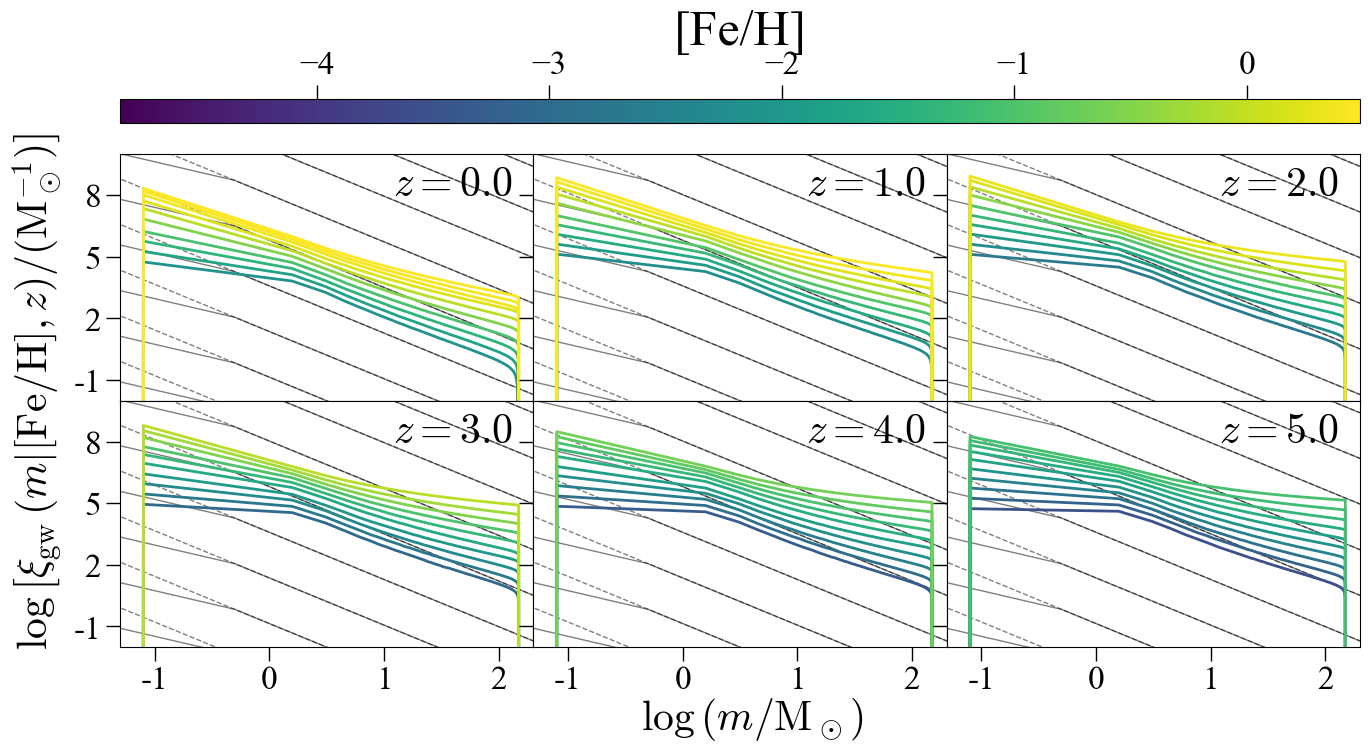

In [33]:
%matplotlib
# 2 LINES 3 COLUMNS

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

flat_fehs = np.concatenate(np.array(zsq_plot_fehs))
cnorm = flat_fehs.max()-flat_fehs.min()


for i, (ax, igimfs, z) in enumerate(zip(axes.flatten(), zsq_plot_igimfs, zsq_plot_zs)):
    for b in np.logspace(-5, 15, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa(m) for m in ms], 'k-', lw=1, alpha=0.5)
    
    
    fehs = zsq_plot_fehs[i]
    logsfrs = zsq_plot_logsfrs[i]
    for igimf, feh, logsfr in zip(igimfs, fehs, logsfrs):
        if all(n>=0 for n in igimf):
            c = cm.viridis((np.abs(feh-flat_fehs.min()))/cnorm)
            if feh == 0 and logsfr == 0:
                c = 'red'
            else:
                ax.plot(plot_ms, igimf, label=f'{feh:.2f}, {logsfr:.2f}', c=c, lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylim(1e-2, 1e10)
    ax.set_yticks([10.**x for x in np.arange(-1, 10, 3)])
    ax.set_yticklabels(np.arange(-1, 10, 3))
        
    ax.set_xlim(0.05, 200)
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_xticklabels(np.arange(-1, 3, 1))
    
    ax.text(0.95, 0.95, f'$z = {z:.1f}$',  ha='right', va='top', transform=ax.transAxes)

fig.text(0.52, 0.05, '$\\log\\left(m/\\mathrm{M}_\\odot\\right)$', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.43, '$\\log\\left[\\xi_\\mathrm{gw}\\,\\left(m|\\mathrm{[Fe/H]},z\\right)/(\\mathrm{M}_\\odot^{-1})\\right]$', rotation=90, ha='right', va='center')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=flat_fehs.min(), vmax=flat_fehs.max()))
cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
cb.set_label('[Fe/H]')

fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto5_thin.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto5_thin.eps', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto5_thin.png', bbox_inches='tight')

Using matplotlib backend: module://matplotlib_inline.backend_inline


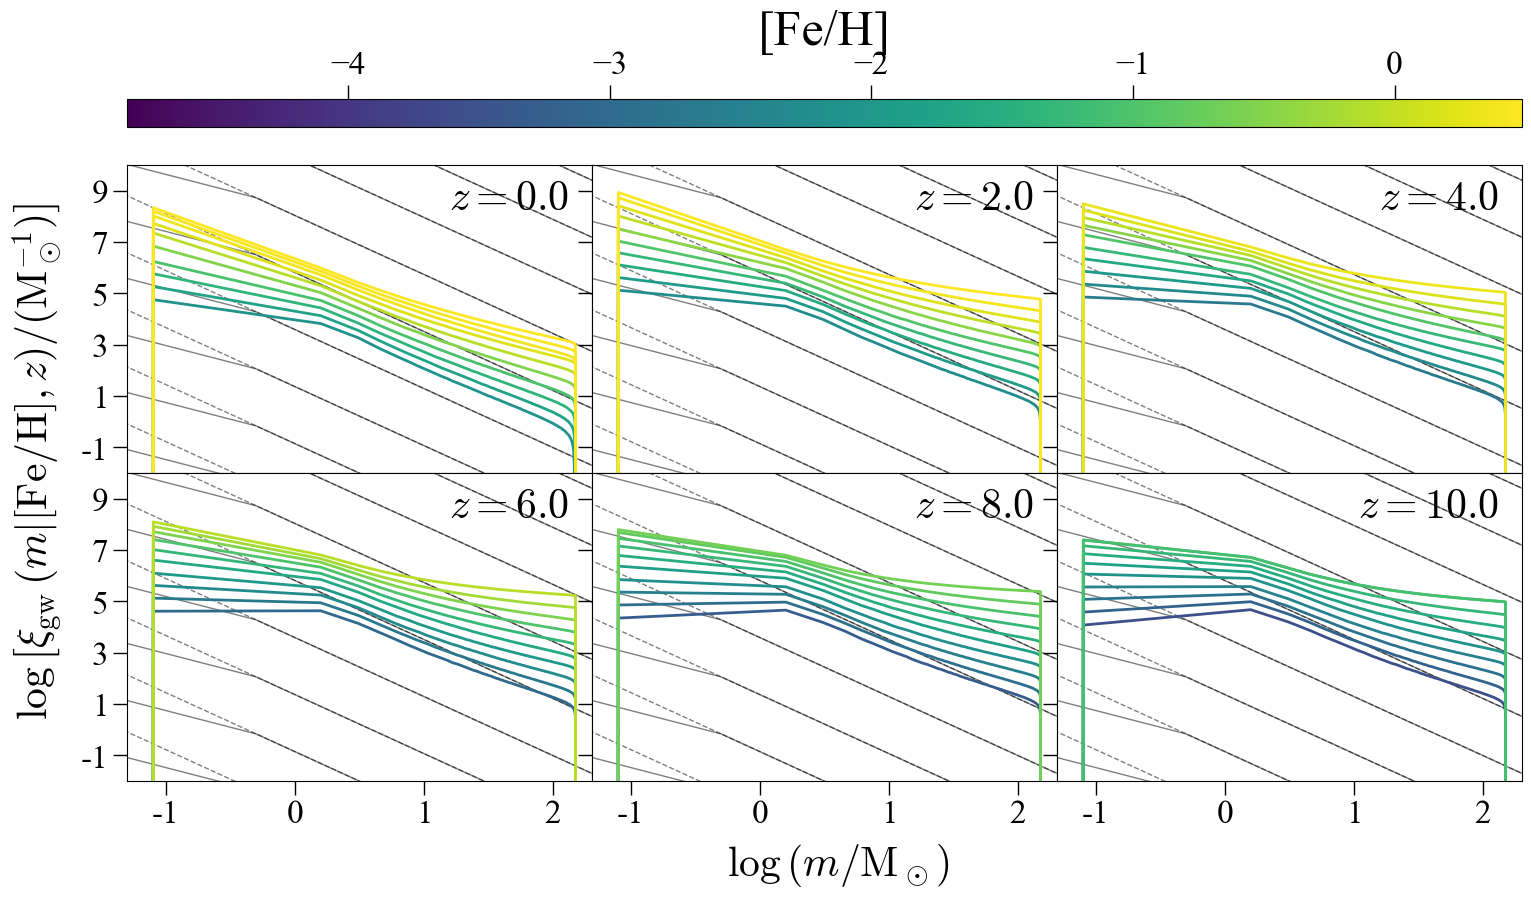

In [32]:
%matplotlib
# 2 LINES 3 COLUMNS

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

flat_fehs = np.concatenate(np.array(zsq_plot_fehs))
cnorm = flat_fehs.max()-flat_fehs.min()


for i, (ax, igimfs, z) in enumerate(zip(axes.flatten(), zsq_plot_igimfs[::2], zsq_plot_zs[::2])):
    for b in np.logspace(-5, 15, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa(m) for m in ms], 'k-', lw=1, alpha=0.5)
    
    fehs = zsq_plot_fehs[i]
    logsfrs = zsq_plot_logsfrs[i]
    for igimf, feh, logsfr in zip(igimfs, fehs, logsfrs):
        if all(n>=0 for n in igimf):
            c = cm.viridis((np.abs(feh-flat_fehs.min()))/cnorm)
            if feh == 0 and logsfr == 0:
                c = 'red'
            else:
                ax.plot(plot_ms, igimf, label=f'{feh:.2f}, {logsfr:.2f}', c=c, lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylim(1e-2, 1e10)
    ax.set_yticks([10.**x for x in np.arange(-1, 10, 2)])
    ax.set_yticklabels(np.arange(-1, 10, 2))
        
    ax.set_xlim(0.05, 200)
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_xticklabels(np.arange(-1, 3, 1))
        
    ax.text(0.95, 0.95, f'$z = {z:.1f}$',  ha='right', va='top', transform=ax.transAxes)

fig.text(0.52, 0.05, '$\\log\\left(m/\\mathrm{M}_\\odot\\right)$', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.43, '$\\log\\left[\\xi_\\mathrm{gw}\\,\\left(m|\\mathrm{[Fe/H]},z\\right)/(\\mathrm{M}_\\odot^{-1})\\right]$', rotation=90, ha='right', va='center')
  
sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=flat_fehs.min(), vmax=flat_fehs.max()))
cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
cb.set_label('[Fe/H]')

fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto10.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto10.png', bbox_inches='tight')

Using matplotlib backend: module://matplotlib_inline.backend_inline


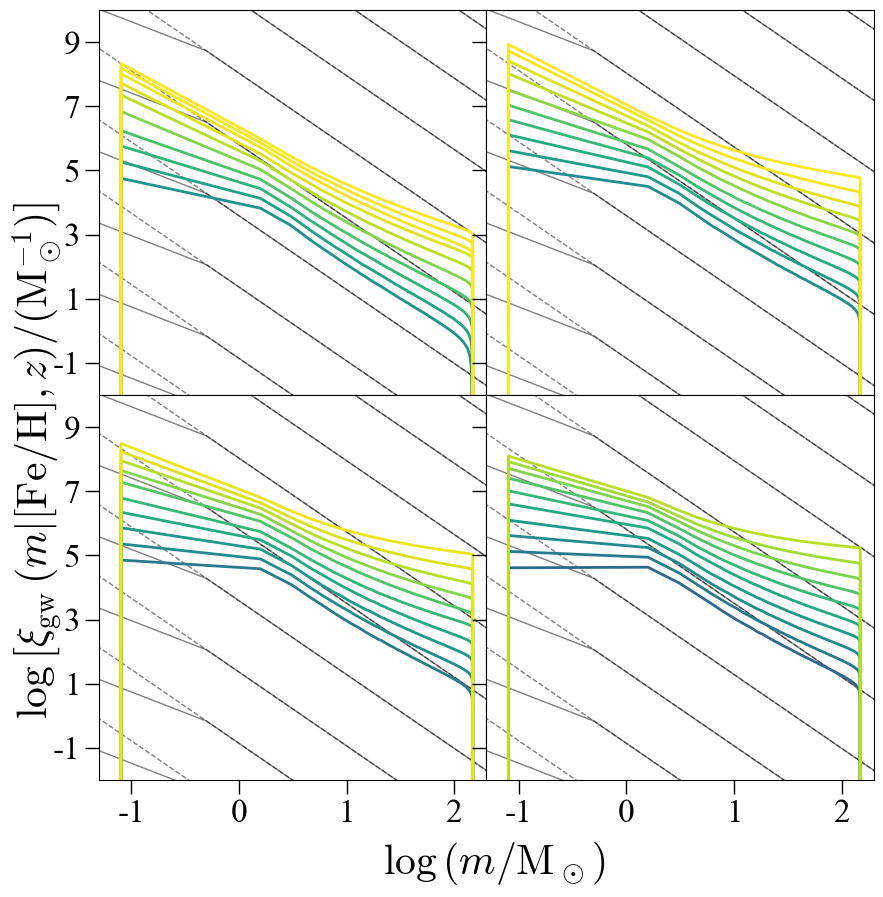

In [28]:
%matplotlib
# 2 LINES 3 COLUMNS

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

flat_fehs = np.concatenate(np.array(zsq_plot_fehs))
cnorm = flat_fehs.max()-flat_fehs.min()


for i, (ax, igimfs, z) in enumerate(zip(axes.flatten(), zsq_plot_igimfs[::2], zsq_plot_zs[::2])):
    for b in np.logspace(-5, 15, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa(m) for m in ms], 'k-', lw=1, alpha=0.5)
    
    fehs = zsq_plot_fehs[i]
    logsfrs = zsq_plot_logsfrs[i]
    for igimf, feh, logsfr in zip(igimfs, fehs, logsfrs):
        if all(n>=0 for n in igimf):
            c = cm.viridis((np.abs(feh-flat_fehs.min()))/cnorm)
            if feh == 0 and logsfr == 0:
                c = 'red'
            else:
                ax.plot(plot_ms, igimf, label=f'{feh:.2f}, {logsfr:.2f}', c=c, lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylim(1e-2, 1e10)
    ax.set_yticks([10.**x for x in np.arange(-1, 10, 2)])
    ax.set_yticklabels(np.arange(-1, 10, 2))
        
    ax.set_xlim(0.05, 200)
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_xticklabels(np.arange(-1, 3, 1))
        
    #ax.text(0.95, 0.95, f'z = {z:.1f}',  ha='right', va='top', transform=ax.transAxes)

fig.text(0.52, 0.05, '$\\log\\left(m/\\mathrm{M}_\\odot\\right)$', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.43, '$\\log\\left[\\xi_\\mathrm{gw}\\,\\left(m|\\mathrm{[Fe/H]},z\\right)/(\\mathrm{M}_\\odot^{-1})\\right]$', rotation=90, ha='right', va='center')
  
#sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=flat_fehs.min(), vmax=flat_fehs.max()))
#cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
#cb.set_label('[Fe/H]')

fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto10_mini.png', bbox_inches='tight')

#### SFR-uniform IMF grid

In [29]:
sfrsq_plot_igimfs = []
sfrsq_plot_fehs = []
sfrsq_plot_logsfrs = []

for sfr in np.unique(sfrsq_grid_df['Log(SFR [Msun yr-1])']):   
    sfrsq_plot_logsfrs.append(sfr)
    print(f'Now working for logsfr={sfr}')
    subdf = sfrsq_grid_df[sfrsq_grid_df['Log(SFR [Msun yr-1])'] == sfr]
    fehs = subdf['[Fe/H]'].to_numpy()
    fehs = fehs[np.argsort(fehs)]
    #fehs = fehs[fehs > -2.5]
    step = len(fehs)//10
    if step == 0 :
        step = 1
    fehs = fehs[::step]
    igimfs = []
    fehss = []
    for feh in fehs:
        fehss.append(feh)
        print(f'Now working for feh={feh}')
        igimf = IGIMF(10**sfr, feh)
        igimf.set_clusters()
        igimf_arr = np.array([igimf.imf(m) for m in plot_ms])
        igimfs.append(igimf_arr)
    print('')
    sfrsq_plot_fehs.append(fehs)
    sfrsq_plot_igimfs.append(igimfs)

Now working for logsfr=-2.0
Now working for feh=-5.0


/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Now working for feh=-4.0
Now working for feh=-3.0
Now working for feh=-2.0
Now working for feh=-1.0
Now working for feh=0.0
Now working for feh=1.0

Now working for logsfr=-1.0
Now working for feh=-5.0
Now working for feh=-4.0
Now working for feh=-3.0
Now working for feh=-2.0
Now working for feh=-1.0
Now working for feh=0.0
Now working for feh=1.0

Now working for logsfr=0.0
Now working for feh=-5.0
Now working for feh=-4.0
Now working for feh=-3.0
Now working for feh=-2.0
Now working for feh=-1.0
Now working for feh=0.0
Now working for feh=1.0

Now working for logsfr=1.0
Now working for feh=-5.0
Now working for feh=-4.0
Now working for feh=-3.0
Now working for feh=-2.0
Now working for feh=-1.0
Now working for feh=0.0
Now working for feh=1.0

Now working for logsfr=2.0
Now working for feh=-5.0
Now working for feh=-4.0
Now working for feh=-3.0
Now working for feh=-2.0
Now working for feh=-1.0
Now working for feh=0.0
Now working for feh=1.0

Now working for logsfr=3.0
Now working for feh

Using matplotlib backend: module://matplotlib_inline.backend_inline


<>:39: SyntaxWarning: invalid escape sequence '\,'
<>:39: SyntaxWarning: invalid escape sequence '\o'
<>:39: SyntaxWarning: invalid escape sequence '\,'
<>:39: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_697743/1969481184.py:39: SyntaxWarning: invalid escape sequence '\,'
  sfr_descr = ax.text(0.95, 0.95, f'SFR = $10^{{{logsfr:.0f}}}\,\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$', transform=ax.transAxes, ha='right', va='top')
/tmp/ipykernel_697743/1969481184.py:39: SyntaxWarning: invalid escape sequence '\o'
  sfr_descr = ax.text(0.95, 0.95, f'SFR = $10^{{{logsfr:.0f}}}\,\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$', transform=ax.transAxes, ha='right', va='top')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


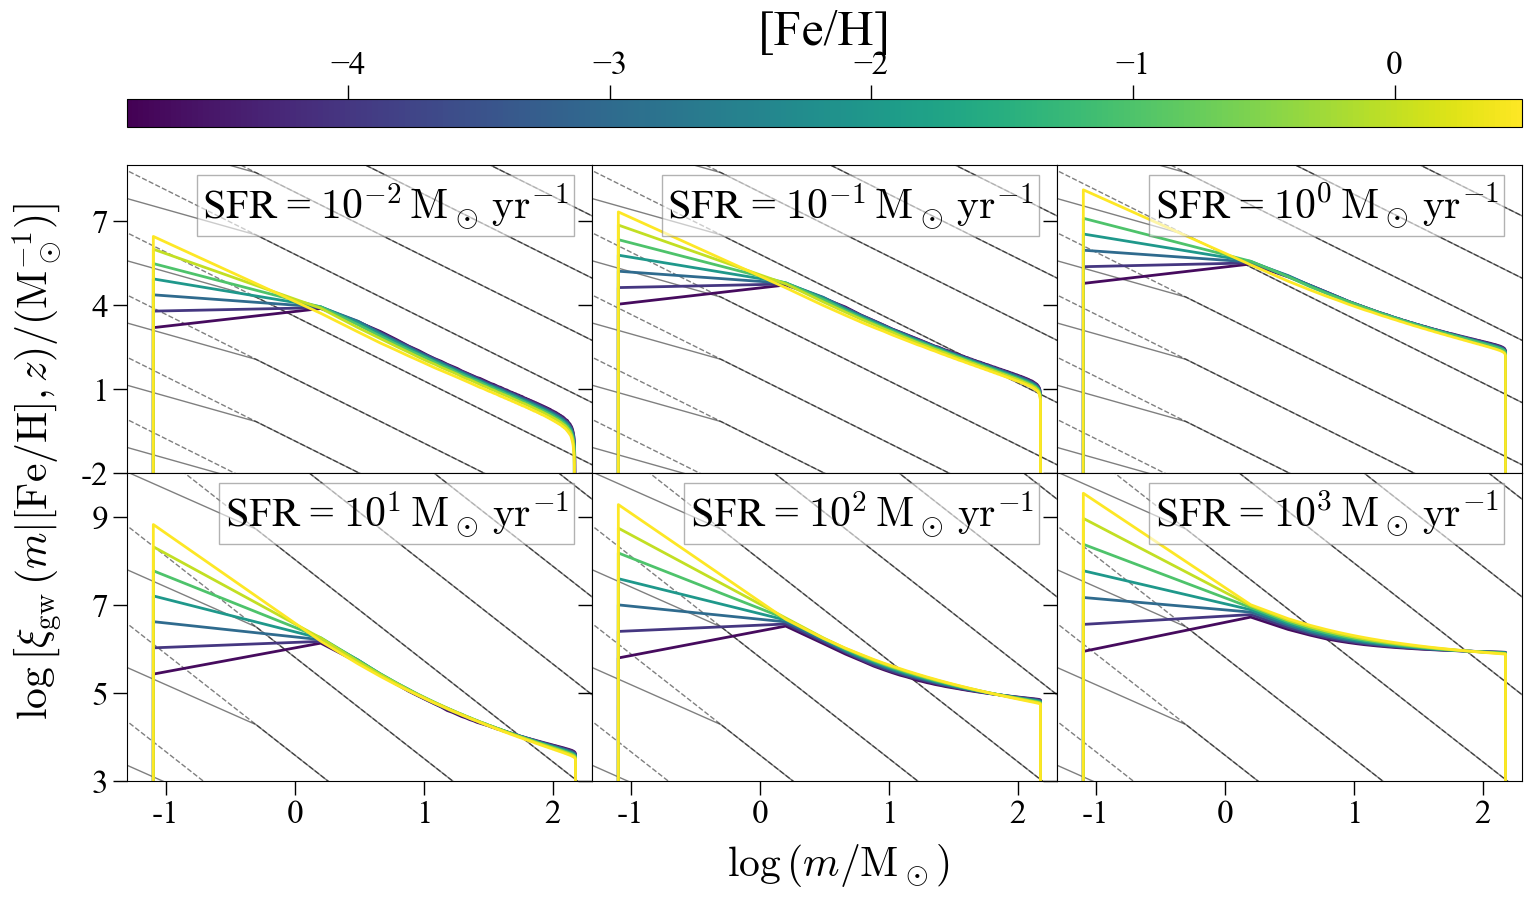

In [30]:
%matplotlib
# 2 LINES 3 COLUMNS

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey='row', sharex=True)#, tight_layout=True)
fig.subplots_adjust(hspace=0, wspace=0) # get rid of white spaces between figures
rect = fig.patch
rect.set_facecolor('white')

flat_fehs = np.concatenate(zsq_plot_fehs)
cnorm = flat_fehs.max()-flat_fehs.min()

col_n = 0
for i, (ax, igimfs, logsfr) in enumerate(zip(axes.flatten(), sfrsq_plot_igimfs, sfrsq_plot_logsfrs)):
    for b in np.logspace(-5, 15, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa(m) for m in ms], 'k-', lw=1, alpha=0.5)
    
    
    fehs = sfrsq_plot_fehs[i]
    for igimf, feh in zip(igimfs, fehs):
        if all(n>=0 for n in igimf):
            c = cm.viridis((np.abs(feh-flat_fehs.min()))/cnorm)
            if feh == 0 and logsfr == 0:
                c = 'red'
            else:
                ax.plot(plot_ms, igimf, label=f'{feh:.2f}', c=c, lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')

    mini = 0
    for imf in igimf[np.argsort(igimf)]:
        if imf != 0:
            igimf_min = imf
            if mini == 0:
                break
            mini += 1

    sfr_descr = ax.text(0.95, 0.95, f'SFR = $10^{{{logsfr:.0f}}}\,\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$', transform=ax.transAxes, ha='right', va='top')
    sfr_descr.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray'))

igimf_min = 1e-2
igimf_max = 1e9
axes[0,0].set_ylim(igimf_min, igimf_max)
logticks = np.arange(np.floor(np.log10(igimf_min)), np.floor(np.log10(igimf_max)), 3)
axes[0,0].set_yticks([10.**x for x in logticks])
axes[0,0].set_yticklabels([f'{t:.0f}' for t in logticks])

igimf_min = 1e3
igimf_max = 1e10
axes[1,0].set_ylim(igimf_min, igimf_max)
logticks = np.arange(np.floor(np.log10(igimf_min)), np.floor(np.log10(igimf_max)), 2)
axes[1,0].set_yticks([10.**x for x in logticks])
axes[1,0].set_yticklabels([f'{t:.0f}' for t in logticks])
    
axes[1,0].set_xlim(0.05, 200)
axes[1,0].set_xticks([10.**x for x in np.arange(-1, 3, 1)])
axes[1,0].set_xticks([], minor=True)
axes[1,0].set_xticklabels(np.arange(-1, 3, 1))    
    

fig.text(0.52, 0.05, '$\\log\\left(m/\\mathrm{M}_\\odot\\right)$', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.43, '$\\log\\left[\\xi_\\mathrm{gw}\\,\\left(m|\\mathrm{[Fe/H]},z\\right)/(\\mathrm{M}_\\odot^{-1})\\right]$', rotation=90, ha='right', va='center')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=flat_fehs.min(), vmax=flat_fehs.max()))
cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
cb.set_label('[Fe/H]')

fig.savefig(FIGURE_FOLDER/'sfr_imfs.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'sfr_imfs.png', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'sfr_imfs.eps', bbox_inches='tight')

<>:44: SyntaxWarning: invalid escape sequence '\,'
<>:44: SyntaxWarning: invalid escape sequence '\o'
<>:44: SyntaxWarning: invalid escape sequence '\,'
<>:44: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_697743/3445888678.py:44: SyntaxWarning: invalid escape sequence '\,'
  sfr_descr = ax.text(0.95, 0.95, f'SFR = $10^{{{logsfr:.0f}}}\,\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$', transform=ax.transAxes, ha='right', va='top')
/tmp/ipykernel_697743/3445888678.py:44: SyntaxWarning: invalid escape sequence '\o'
  sfr_descr = ax.text(0.95, 0.95, f'SFR = $10^{{{logsfr:.0f}}}\,\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$', transform=ax.transAxes, ha='right', va='top')


Using matplotlib backend: module://matplotlib_inline.backend_inline


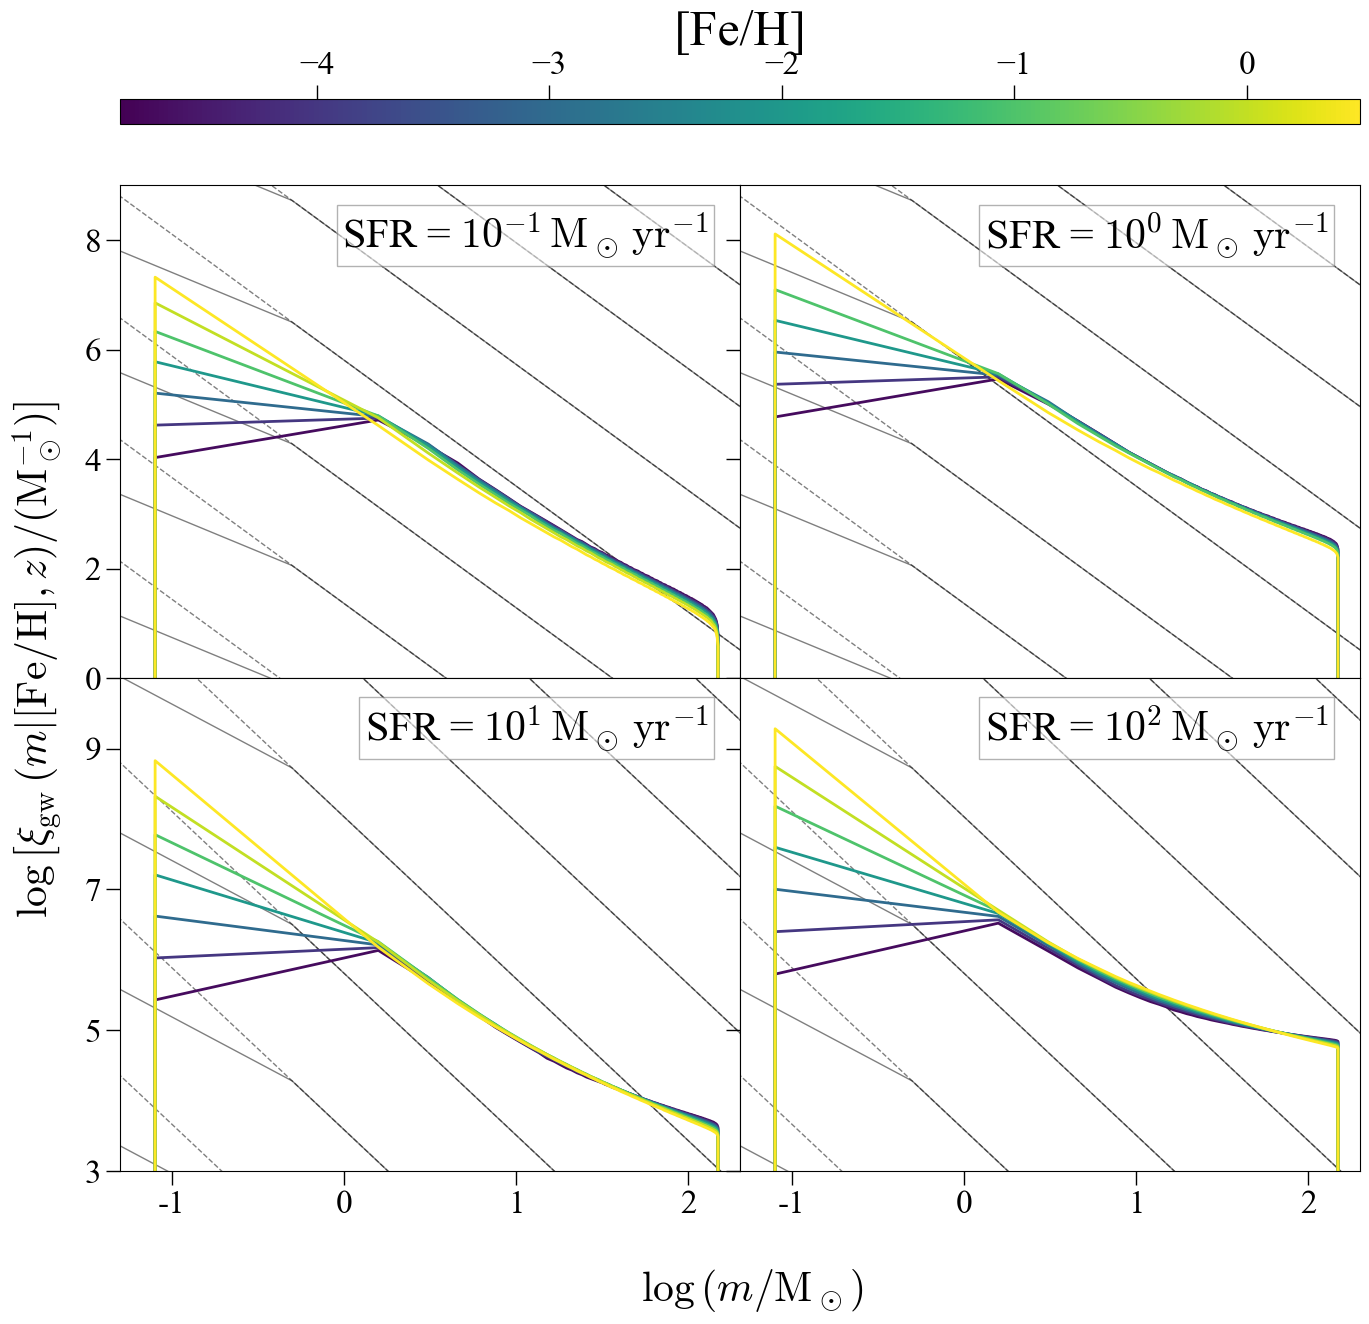

In [31]:
%matplotlib
# 2 LINES 2 COLUMNS

fig, axes = plt.subplots(2, 2, figsize=(16, 16), sharey='row', sharex=True)#, tight_layout=True)
fig.subplots_adjust(hspace=0, wspace=0) # get rid of white spaces between figures
rect = fig.patch
rect.set_facecolor('white')

flat_fehs = np.concatenate(zsq_plot_fehs)
cnorm = flat_fehs.max()-flat_fehs.min()

col_n = 0
for i, (ax, igimfs, logsfr) in enumerate(zip(axes.flatten(), sfrsq_plot_igimfs[1:-1], sfrsq_plot_logsfrs[1:-1])):
    for b in np.logspace(-5, 15, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa(m) for m in ms], 'k-', lw=1, alpha=0.5)
    
    
    fehs = sfrsq_plot_fehs[i]
    for igimf, feh in zip(igimfs, fehs):
        if all(n>=0 for n in igimf):
            c = cm.viridis((np.abs(feh-flat_fehs.min()))/cnorm)
            if feh == 0 and logsfr == 0:
                c = 'red'
            else:
                ax.plot(plot_ms, igimf, label=f'{feh:.2f}', c=c, lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')

    mini = 0
    for imf in igimf[np.argsort(igimf)]:
        if imf != 0:
            igimf_min = imf
            if mini == 0:
                break
            mini += 1
       
    ax.set_xlim(0.05, 200)
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_xticklabels(np.arange(-1, 3, 1))
    
    sfr_descr = ax.text(0.95, 0.95, f'SFR = $10^{{{logsfr:.0f}}}\,\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$', transform=ax.transAxes, ha='right', va='top')
    sfr_descr.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray'))

igimf_min = 1e0
igimf_max = 1e9
axes[0,0].set_ylim(igimf_min, igimf_max)
logticks = np.arange(np.floor(np.log10(igimf_min)), np.floor(np.log10(igimf_max)), 2)
axes[0,0].set_yticks([10.**x for x in logticks])
axes[0,0].set_yticklabels([f'{t:.0f}' for t in logticks])

igimf_min = 1e3
igimf_max = 1e10
axes[1,0].set_ylim(igimf_min, igimf_max)
logticks = np.arange(np.floor(np.log10(igimf_min)), np.floor(np.log10(igimf_max)), 2)
axes[1,0].set_yticks([10.**x for x in logticks])
axes[1,0].set_yticklabels([f'{t:.0f}' for t in logticks])
    
fig.text(0.52, 0.05, '$\\log\\left(m/\\mathrm{M}_\\odot\\right)$', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.43, '$\\log\\left[\\xi_\\mathrm{gw}\\,\\left(m|\\mathrm{[Fe/H]},z\\right)/(\\mathrm{M}_\\odot^{-1})\\right]$', rotation=90, ha='right', va='center')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=flat_fehs.min(), vmax=flat_fehs.max()))
cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
cb.set_label('[Fe/H]')

fig.savefig(FIGURE_FOLDER/'sfr_imfs_square.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'sfr_imfs_square.png', bbox_inches='tight')